## Author : Ibrahim Sobh
### Kaggle House Prices - Advanced Regression Technique.
- Predict sales prices and practice feature engineering, RFs, and gradient boosting

# I - First Section :  Model Training

## 1 - Importing Libraries & Loading Data

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,r2_score
from sklearn.preprocessing import OrdinalEncoder,StandardScaler


# Load Data

data=pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')

## 2 - Display Raw Data

In [3]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3 - Split Data into Train | Test | Validation

In [4]:
## Differentiate between Features & Target (Sale Price)

X = data.loc[:, data.columns != 'SalePrice']
y = data.SalePrice

# Decide test and validation size

test_size =0.20

validation_size=0.20

# Split Train / Test

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=1-test_size,random_state = 42)

# Split Train / Validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=1-validation_size, random_state=42)

print('train:', len(X_train), 'test:', len(X_test),'validation:', len(X_val))

train: 934 test: 292 validation: 234


## 4 - Preprocessing


## 4.1 Preprocessing:  Check up for columns with missing Data

In [5]:
# Check X_Train Data

missing_in_train=X_train.isnull().sum().sort_values(ascending=False).head(12) / len(X_train) *100
round(missing_in_train,2)

PoolQC          99.36
MiscFeature     95.93
Alley           93.47
Fence           80.19
FireplaceQu     45.93
LotFrontage     18.63
GarageType       5.46
GarageYrBlt      5.46
GarageQual       5.46
GarageCond       5.46
GarageFinish     5.46
BsmtCond         2.46
dtype: float64

In [6]:
# Check X_val Data

missing_in_validation=X_val.isnull().sum().sort_values(ascending=False).head(12) / len(X_val) *100
round(missing_in_validation,2)

PoolQC          100.00
MiscFeature      96.58
Alley            94.44
Fence            79.49
FireplaceQu      50.43
LotFrontage      18.38
GarageType        5.56
GarageYrBlt       5.56
GarageQual        5.56
GarageCond        5.56
GarageFinish      5.56
BsmtFinType2      2.14
dtype: float64

## 4.2 - Preprocessing:  Drop Unwanted Columns ( columns with to much missing data)

In [7]:
# Drop X_train unwanted columns

X_train.drop(["PoolQC", "MiscFeature","Alley","Fence","FireplaceQu"], axis = 1, inplace = True)

# Drop X_val unwanted columns

X_val.drop(["PoolQC", "MiscFeature","Alley","Fence","FireplaceQu"], axis = 1, inplace = True)

## 4.3 - Preprocessing:  Encode Categorical Features 

In [8]:
oe = OrdinalEncoder()

# X_Train Categories Encoding

X_train_categorical = X_train.select_dtypes(include=['object']).columns
X_train_numerical= X_train.select_dtypes([np.int64,np.float64]).columns

X_train[X_train_categorical]=oe.fit_transform(X_train[X_train_categorical])

# X_val Categories Encoding

X_val_categorical = X_val.select_dtypes(include=['object']).columns
X_val_numerical= X_val.select_dtypes([np.int64,np.float64]).columns

X_val[X_val_categorical]=oe.fit_transform(X_val[X_val_categorical])

## 4.4 - Preprocessing:   Fill Features with Null /NA values

In [9]:
# X_Train Columns with acceptable rate of Missing Values

missing_in_train=X_train.isnull().sum().sort_values(ascending=False).head(12) / len(X_train) *100
print(round(missing_in_train,2))

LotFrontage     18.63
GarageType       5.46
GarageYrBlt      5.46
GarageFinish     5.46
GarageQual       5.46
GarageCond       5.46
BsmtExposure     2.46
BsmtQual         2.46
BsmtFinType2     2.46
BsmtCond         2.46
BsmtFinType1     2.46
MasVnrType       0.54
dtype: float64


In [10]:
# X_val Columns with acceptable rate of Missing Values

missing_in_validation=X_val.isnull().sum().sort_values(ascending=False).head(12) / len(X_val) *100
print(round(missing_in_validation,2))

LotFrontage     18.38
GarageType       5.56
GarageYrBlt      5.56
GarageFinish     5.56
GarageQual       5.56
GarageCond       5.56
BsmtFinType1     2.14
BsmtQual         2.14
BsmtCond         2.14
BsmtExposure     2.14
BsmtFinType2     2.14
MasVnrArea       0.43
dtype: float64


In [11]:
# X_Train Use 'fillna' & interpolate (forward /backward) fill missing values

X_train[X_train_numerical]=X_train[X_train_numerical].fillna(X_train[X_train_numerical].mean())

for feature in X_train_categorical:
    X_train[feature].interpolate(method ='linear', limit_direction ='forward', inplace=True)
    X_train[feature].interpolate(method ='linear', limit_direction ='backward',inplace=True)
    
# X_val Use 'fillna' & interpolate (forward /backward) fill missing values

X_val[X_val_numerical]=X_val[X_val_numerical].fillna(X_val[X_val_numerical].mean())

for feature in X_val_categorical:
    X_val[feature].interpolate(method ='linear', limit_direction ='forward', inplace=True)
    X_val[feature].interpolate(method ='linear', limit_direction ='backward',inplace=True)

In [12]:
# X_train after Filling Missing Data

missing_in_train=X_train.isnull().sum().sort_values(ascending=False).head(12) / len(X_train) *100
round(missing_in_train,2)

Id              0.0
GarageType      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
FullBath        0.0
BsmtHalfBath    0.0
BsmtFullBath    0.0
GrLivArea       0.0
dtype: float64

In [13]:
# X_val after Filling Missing Data

missing_in_validation=X_val.isnull().sum().sort_values(ascending=False).head(12) / len(X_val) *100
round(missing_in_validation,2)

Id              0.0
GarageType      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
FullBath        0.0
BsmtHalfBath    0.0
BsmtFullBath    0.0
GrLivArea       0.0
dtype: float64

## 5.0 -  Features Selection

## 5.1 - Features Selection:  Test Correlation between Target &  Features

In [14]:
corr_with=X_train.corrwith(y_train).sort_values(ascending=False)
print(corr_with[corr_with>0].head(20),"\n-------------------------")
print(corr_with[corr_with<0].tail(20))

OverallQual     0.777892
GrLivArea       0.674807
GarageCars      0.637454
GarageArea      0.616631
TotalBsmtSF     0.593411
1stFlrSF        0.588018
FullBath        0.550514
YearBuilt       0.515217
TotRmsAbvGrd    0.508304
YearRemodAdd    0.492897
Fireplaces      0.464652
GarageYrBlt     0.462061
MasVnrArea      0.440810
Foundation      0.369088
BsmtFinSF1      0.351121
WoodDeckSF      0.307913
LotFrontage     0.295260
2ndFlrSF        0.284592
OpenPorchSF     0.281425
CentralAir      0.266966
dtype: float64 
-------------------------
LotConfig       -0.019160
MiscVal         -0.020882
BsmtFinType1    -0.044266
BsmtHalfBath    -0.045244
SaleType        -0.052541
BldgType        -0.063664
MSSubClass      -0.088854
OverallCond     -0.095197
Heating         -0.102708
EnclosedPorch   -0.133094
KitchenAbvGr    -0.137487
MSZoning        -0.177318
LotShape        -0.238801
BsmtExposure    -0.301859
GarageType      -0.320802
HeatingQC       -0.410004
GarageFinish    -0.464363
KitchenQual     

## 5.2 - Features Selection:  Select  Features based on Best Correlation

<AxesSubplot:>

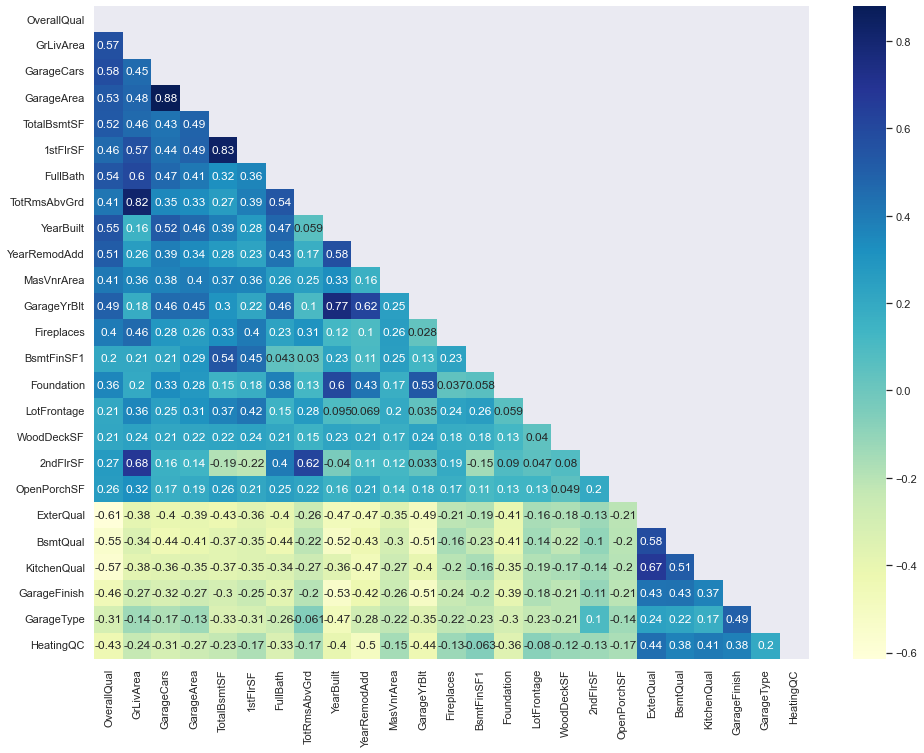

In [15]:
list_of_features =["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF",
                  "1stFlrSF","FullBath","TotRmsAbvGrd","YearBuilt","YearRemodAdd",
                  "MasVnrArea","GarageYrBlt","Fireplaces","BsmtFinSF1","Foundation",
                  "LotFrontage","WoodDeckSF","2ndFlrSF","OpenPorchSF",
                  "ExterQual","BsmtQual","KitchenQual","GarageFinish","GarageType","HeatingQC"]


X = X_train[list_of_features]
y = y_train
corr = X.corr()
sns.set(rc = {'figure.figsize':(16,12)})
sns.heatmap(corr,mask=((np.triu(np.ones_like(corr)))),cmap="YlGnBu",annot=True)


- __Seeing this heat map we can remove the features with very high correlations between each other so we have unique features__

- __we need ro remove one of "GarageArea" or "GarageCars"__
- __we need ro remove one of ,"TotalBsmtSF","1stFlrSF" ...__




## 5.3 - Features Selection:  Decide the best Feature to continue with ( Least Collinear)

<AxesSubplot:>

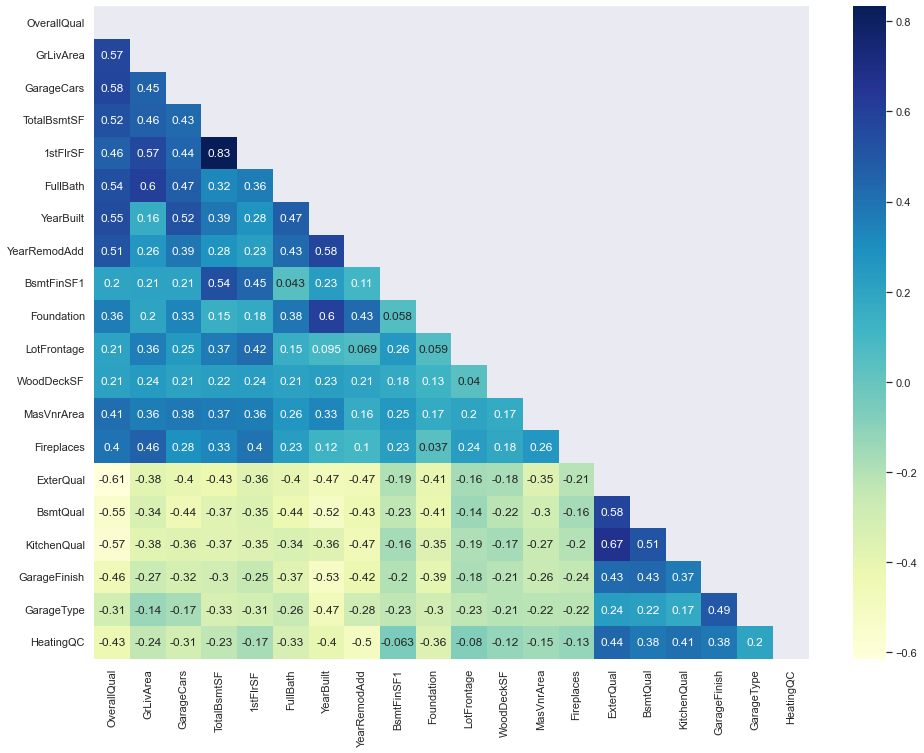

In [16]:
list_of_features =["OverallQual","GrLivArea","GarageCars","TotalBsmtSF","1stFlrSF",
                  "FullBath","YearBuilt","YearRemodAdd","BsmtFinSF1","Foundation",
                  "LotFrontage","WoodDeckSF","MasVnrArea","Fireplaces",
                  "ExterQual","BsmtQual","KitchenQual","GarageFinish","GarageType","HeatingQC"]

X = X_train[list_of_features]
y = y_train
corr = X.corr()
sns.set(rc = {'figure.figsize':(16,12)})
sns.heatmap(corr,mask=((np.triu(np.ones_like(corr)))),cmap="YlGnBu",annot=True)

## 6 -  Scale Data ( Standard Scaler )

In [17]:
scalar =StandardScaler()

# Scale X_train 

X_train=pd.DataFrame(scalar.fit_transform(X_train),columns = X_train.columns)

# Scale X_val
X_val=pd.DataFrame(scalar.fit_transform(X_val),columns = X_val.columns)

In [18]:
# For Metrics and Exporting Data

def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)

def export_Submission_file(predicition_dataframe,output_file_name):
    Output = pd.DataFrame()
    Output['Id'] = predicition_dataframe['Id']
    Output['SalePrice'] = predicition_dataframe['y_pred']
    Output.to_csv("../"+output_file_name+".txt", index=False)

## 7.0 - Model Training 

## 7.1- Model Training :  Linear Regression [ First Model ]

In [19]:
LR_model = LinearRegression()

X = X_train[list_of_features]
y = y_train

LR_model.fit(X, y)

y_pred=LR_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Training Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Training Set 
Root-Mean-Squared-Error : 0.164
R2 : 0.7929


## 7.2- Model Training :  Model Validation on Validation Set  [ First Model ]

In [20]:
X = X_val[list_of_features]
y = y_val

y_pred=LR_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Validation Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Validation Set 
Root-Mean-Squared-Error : 0.164
R2 : 0.8471


## 7.3- Model Training :  Random Forest Regressor [ Second Model ]

In [21]:
Regr_model = RandomForestRegressor(n_estimators=1000,max_depth=40, random_state=50,criterion="squared_error")

X = X_train[list_of_features]
y = y_train

Regr_model.fit(X, y)

y_pred=Regr_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Training Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Training Set 
Root-Mean-Squared-Error : 0.065
R2 : 0.9726


## 7.4- Model Training :  Model Validation on Validation Set  [ Second Model ]

In [22]:
X = X_val[list_of_features]
y = y_val

y_pred=Regr_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Validation Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Validation Set 
Root-Mean-Squared-Error : 0.156
R2 : 0.8764


# II - Second Section :  Model Evaluation

## 1.0 - Preprocessing

## 1.1 Preprocessing:  Check up for columns with missing Data

In [23]:
# Check X_Test Data

missing_in_test =X_test.isnull().sum().sort_values(ascending=False).head(12) / len(X_test) *100
round(missing_in_test,2)

PoolQC          99.66
MiscFeature     97.26
Alley           94.18
Fence           83.56
FireplaceQu     48.97
LotFrontage     14.38
GarageType       5.82
GarageYrBlt      5.82
GarageQual       5.82
GarageCond       5.82
GarageFinish     5.82
BsmtFinType2     3.42
dtype: float64

## 1.2 - Preprocessing:  Drop Unwanted Columns ( columns with to much missing data)

In [24]:
# Clean X_test

X_test.drop(["PoolQC", "MiscFeature","Alley","Fence","FireplaceQu"], axis = 1, inplace = True) 

## 1.3 - Preprocessing:  Encode Categorical Features 

In [25]:
oe = OrdinalEncoder()

# X_Test Categories Encoding

X_test_categorical = X_test.select_dtypes(include=['object']).columns
X_test_numerical= X_test.select_dtypes([np.int64,np.float64]).columns

X_test[X_test_categorical]=oe.fit_transform(X_test[X_test_categorical])

## 1.4 - Preprocessing:   Fill Features with Null /NA values

In [26]:
# X_Test Use 'fillna' & interpolate (forward /backward) fill missing values

X_test[X_test_numerical]=X_test[X_test_numerical].fillna(X_test[X_test_numerical].mean())

for feature in X_test_categorical:
    X_test[feature].interpolate(method ='linear', limit_direction ='forward', inplace=True)
    X_test[feature].interpolate(method ='linear', limit_direction ='backward',inplace=True)
    

In [27]:
# Check X_Test Data

missing_in_test =X_test.isnull().sum().sort_values(ascending=False).head(12) / len(X_test) *100
round(missing_in_test,2)

Id              0.0
GarageType      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
FullBath        0.0
BsmtHalfBath    0.0
BsmtFullBath    0.0
GrLivArea       0.0
dtype: float64

## 2 -  Scale Data ( Standard Scaler )

In [28]:
scalar =StandardScaler()

# Scale X_test

X_test=pd.DataFrame(scalar.fit_transform(X_test),columns = X_test.columns)

## 3.0 - Model Evaluation

## 3.1 - Model Evaluation :  Model Validation on Validation Set  [ First Model ]

In [29]:
X = X_test[list_of_features]
y = y_test

y_pred=LR_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Validation Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Validation Set 
Root-Mean-Squared-Error : 0.184
R2 : 0.8223


## 3.2 - Model Evaluation : Random Forest Regressor [ Second Model ]

In [30]:
X = X_test[list_of_features]
y = y_test

y_pred=Regr_model.predict(X)

y_pred=y_pred.ravel()
y_pred =abs(y_pred)
y= y.ravel()

print("Validation Set ")
print("Root-Mean-Squared-Error :",compute_rmsle(y,y_pred,3))
print("R2 :",round(r2_score(y,y_pred),4))

Validation Set 
Root-Mean-Squared-Error : 0.163
R2 : 0.8758
